In [1]:
%load_ext autoreload
%autoreload 2

Strategies for training DNN:

Upsampling strategies:

1- Resample the minority classes such that in half of the data, one of the first 12 classes have positive probabilities (the other half has zero probabilities for the first 12 classes).

2- Resample the minority classes such that each class has the same number of observations as class 14 (#b). 

3- Resample the minority classes such that each class has the same number of observations as class 13 (h#).

Changing the objective function:

1- KL divergence

2- CrossEntropyLoss

3- CrossEntropyLoss with weights given to 12 classes.

3- Train with single class labels (rather than vectors).

Changing the architecture:

1- More layers or less layers.

2- Relu or sigmoid activation functions.

Chaning the data:

1- Aggregate class labes (1 class per phoneme)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import DNN_utils
from DNN_utils import *
#from DNN_utils import (flatten, column_str_to_numpy, check_accuracy, check_loss, check_accuracy_12_classes)
from torch.utils.data import Dataset, DataLoader, sampler

import numpy as np 
import pandas as pd
from joblib import load 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Import helper functions.
import mfcc_label 
import get_prob

# Read the data
df_train_val = pd.read_csv('processed_data/dnn_never_train.csv')
df_test = pd.read_csv('processed_data/dnn_never_test.csv')

# Some columns are recorded as string although they are arrays.
column_str_to_numpy(df_train_val, 'mfcc')
column_str_to_numpy(df_train_val, 'label')
column_str_to_numpy(df_test, 'mfcc')
column_str_to_numpy(df_test, 'label')

#Split the train set into train and validation sets.
df_train_pre, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42)
df_train_pre.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

# Create a single class label (type: int) which is the highest probability class in the label vector (type: 14x1 array).
df_train_pre['single_class_label'] = df_train_pre['label'].apply(lambda x: np.argmax(x))
df_val['single_class_label'] = df_val['label'].apply(lambda x: np.argmax(x))
df_test['single_class_label'] = df_test['label'].apply(lambda x: np.argmax(x))

# Configurations 
#NUM_TRAIN = int(0.8*len(df_train_pre)) # Number of training examples for splitting training and validation datasets. 
#NUM_ROWS = len(df_train_pre)
device = DNN_utils.device
dtype = DNN_utils.dtype

# DNN Architecture Hyperparameters
minibatch_size = 64

In [3]:
print(len(df_train_val))
print(len(df_train_pre))
print(len(df_val)) 


15493
12394
3099


In [4]:
'''
pd.set_option('display.max_colwidth', None)

# Upsample from observations that give positive probability on one of the 12 classes that correspond to 'never'. 
def upsample_minority(df, mask):
    from sklearn.utils import resample
    df_minority = df[mask]
    df_majority = df[~mask]

    df_minority_upsampled = resample(df_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=len(df_majority),    # to match majority class
                                    random_state=42) # reproducible results

    df_upsampled = pd.concat([df_majority, df_minority_upsampled])
    return df_upsampled

mask = df_train_pre['label'].apply(lambda x: any(elem > 0 for elem in x[:12]))
#mask = df_train_pre['label'].apply(lambda x: all(elem == 0 for elem in x[12:]))
df_train = upsample_minority(df_train_pre, mask)

print('Before upsampling:')
display(df_train_pre['label'].apply(lambda x: any(elem > 0 for elem in x[:12])).value_counts()) 

# Display new class counts
print('After upsampling:')
display(df_train['label'].apply(lambda x: any(elem > 0 for elem in x[:12])).value_counts()) 
'''


"\npd.set_option('display.max_colwidth', None)\n\n# Upsample from observations that give positive probability on one of the 12 classes that correspond to 'never'. \ndef upsample_minority(df, mask):\n    from sklearn.utils import resample\n    df_minority = df[mask]\n    df_majority = df[~mask]\n\n    df_minority_upsampled = resample(df_minority,\n                                    replace=True,     # sample with replacement\n                                    n_samples=len(df_majority),    # to match majority class\n                                    random_state=42) # reproducible results\n\n    df_upsampled = pd.concat([df_majority, df_minority_upsampled])\n    return df_upsampled\n\nmask = df_train_pre['label'].apply(lambda x: any(elem > 0 for elem in x[:12]))\n#mask = df_train_pre['label'].apply(lambda x: all(elem == 0 for elem in x[12:]))\ndf_train = upsample_minority(df_train_pre, mask)\n\nprint('Before upsampling:')\ndisplay(df_train_pre['label'].apply(lambda x: any(elem > 0 

In [5]:
from sklearn.utils import resample
pd.set_option('display.max_colwidth', None)

def upsample_multiple_minority(df):

    # Assuming df_train_pre is your dataframe
    # Identify majority and minority classes
    majority_classes = [13, 14]
    minority_classes = list(range(13))

    # Find the size of the smallest majority class
    majority_class_size = df_train_pre['single_class_label'].value_counts().nlargest(2).iloc[1]
    
    # List to hold the upsampled dataframes
    list_df = []

    # Loop through each minority class and upsample
    for class_value in minority_classes:
        df_minority_class = df_train_pre[df_train_pre['single_class_label'] == class_value]
        df_minority_upsampled = resample(df_minority_class, 
                                        replace=True,     # sample with replacement
                                        n_samples=majority_class_size,    # to match majority class size
                                        random_state=123) # reproducible results
        list_df.append(df_minority_upsampled)

    # Append majority classes without change
    df_majority = df_train_pre[df_train_pre['single_class_label'].isin(majority_classes)]
    list_df.append(df_majority)

    # Concatenate all dataframes
    df_upsampled = pd.concat(list_df)
    return df_upsampled

df_train = upsample_multiple_minority(df_train_pre)
df_train.reset_index(drop=True, inplace=True)
display(df_train)


,mfcc,label,state_weights,single_class_label
0,"[-705.99225, 71.87973, 32.35219, 36.1934, 41.28257, 2.7530541, -1.9872639, 22.898275, -9.932304, -15.586997, -8.986916, -20.780283, -1.1563901, 4.5018673, -9.66007, -31.509727, 1.0515851, -8.567638, -3.725089, 8.328537]","[0.5575, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4425]","{'#b': 0.4425, 'b-n': 0.5575}",0
1,"[-466.86948, 131.32242, -27.895485, -17.326698, -14.464546, 11.196297, -12.233515, -23.445066, -16.804337, 18.757277, 0.8819246, 1.260014, -5.4004154, 12.914358, -27.524231, 5.572198, -12.900546, -7.520482, -8.263817, 2.8675315]","[0.81916667, 0.18083333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","{'b-n': 0.8191666666666697, 'm-n': 0.1808333333333303}",0
2,"[-487.07132, 135.9779, -3.025653, -9.435239, -3.4786983, 1.6876291, -20.943718, -7.8202906, 14.812183, 8.936998, 15.624887, -38.165127, -3.2568831, 6.699148, 6.8093796, -13.3633795, -4.9855833, 6.2166805, -5.063633, 0.8156262]","[0.7725, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2275]","{'#b': 0.2275, 'b-n': 0.7725}",0
3,"[-504.30026, 167.75624, -43.991325, -12.616833, 17.761126, -22.669508, -22.600502, -32.012856, -13.214453, 23.409264, -22.854027, -14.643912, 1.8293163, 5.0488992, -20.995512, -6.752759, -0.42442548, -4.7568603, -8.2071056, -18.368492]","[0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4]","{'#b': 0.4, 'b-n': 0.6}",0
4,"[-522.470398, 114.880325, -28.6871605, 60.610611, -33.066246, -22.5851097, -2.70186663, 11.0690565, -11.3093596, -39.6996803, -7.85373592, 0.471425563, -3.77920032, 1.12888217, -12.4821405, -17.5289898, 3.33738279, -5.42973566, -11.7449684, -10.3080702]","[0.58333333, 0.41666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","{'b-n': 0.5833333333333303, 'm-n': 0.4166666666666697}",0
...,...,...,...,...
32377,"[-354.37424, 153.82423, 2.520186, 8.557072, -62.9833, -70.76247, 31.027435, -28.974052, -1.3362603, -6.622672, -28.985481, 6.8635836, -23.302856, 17.592358, 1.9556779, -8.322697, 1.6778979, -5.984693, -9.394501, -18.730194]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",{'#b': 1.0},13
32378,"[-541.0925, -20.647453, -19.415312, -3.7550635, -25.011345, 7.143332, -16.555939, -10.724681, 13.894259, 10.9246235, -23.339613, -8.79563, 11.684788, 1.0004408, 9.840512, -4.0137005, 5.4408083, -1.9365463, -10.327684, 1.4280273]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",{'#b': 1.0},13
32379,"[-361.39725, 200.15135, -11.198521, -74.57884, -26.557076, -30.454882, -26.454899, -23.900236, -6.9710026, 10.228376, -62.84133, 9.395352, -1.8819872, -2.3180122, 9.137184, -22.453075, 9.633455, -0.8796562, -26.236694, -2.5513773]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",{'#b': 1.0},13
32380,"[-560.96643, 85.371414, -12.350075, -33.760818, -45.370388, 11.333093, -5.9454966, -0.63891798, 3.0575819, -33.63752, 20.533573, 1.9418074, 10.326906, 4.8501635, -0.17955418, -8.1675873, -6.8336906, 10.819086, -4.0187063, -1.4526093]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",{'#b': 1.0},13


In [6]:

display(pd.DataFrame([df_train['single_class_label'].value_counts(),df_train_pre['single_class_label'].value_counts()]))

#Questions:
#1- MFCC's that correspond to the same phoneme are closer in the feature space.
#   Should we take advantage of this while oversampling? (e.g. taking convex combination of two observations.)


single_class_label,13,0,1,2,3,4,5,6,7,8,9,10,11,12
count,8319,1851,1851,1851,1851,1851,1851,1851,1851,1851,1851,1851,1851,1851
count,8319,204,179,180,252,239,233,138,146,148,159,166,180,1851


In [7]:
load('processed_data/train_test_dataset_never.joblib')['test'] 

[('timit/data/TRAIN/DR2/FPJF0/SX146.WAV',
  'timit/data/TRAIN/DR2/FPJF0/SX146.PHN',
  'timit/data/TRAIN/DR2/FPJF0/SX146.WRD'),
 ('timit/data/TRAIN/DR3/MDBB1/SX376.WAV',
  'timit/data/TRAIN/DR3/MDBB1/SX376.PHN',
  'timit/data/TRAIN/DR3/MDBB1/SX376.WRD'),
 ('timit/data/TRAIN/DR5/MPMB0/SX61.WAV',
  'timit/data/TRAIN/DR5/MPMB0/SX61.PHN',
  'timit/data/TRAIN/DR5/MPMB0/SX61.WRD'),
 ('timit/data/TRAIN/DR4/MJLS0/SX376.WAV',
  'timit/data/TRAIN/DR4/MJLS0/SX376.PHN',
  'timit/data/TRAIN/DR4/MJLS0/SX376.WRD'),
 ('timit/data/TRAIN/DR3/MTJM0/SX146.WAV',
  'timit/data/TRAIN/DR3/MTJM0/SX146.PHN',
  'timit/data/TRAIN/DR3/MTJM0/SX146.WRD'),
 ('timit/data/TRAIN/DR7/MBBR0/SX425.WAV',
  'timit/data/TRAIN/DR7/MBBR0/SX425.PHN',
  'timit/data/TRAIN/DR7/MBBR0/SX425.WRD'),
 ('timit/data/TRAIN/DR5/FCDR1/SX376.WAV',
  'timit/data/TRAIN/DR5/FCDR1/SX376.PHN',
  'timit/data/TRAIN/DR5/FCDR1/SX376.WRD'),
 ('timit/data/TRAIN/DR4/MLJC0/SI1855.WAV',
  'timit/data/TRAIN/DR4/MLJC0/SI1855.PHN',
  'timit/data/TRAIN/DR4/MLJC

In [8]:
# Convert dataset into a format that torch can read.
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, train=True):
        # Convert the DataFrame to tensors or appropriate formats initially
        self.mfcc = torch.tensor(np.vstack(dataframe['mfcc'].to_list()), dtype=torch.float32)
        self.label = torch.tensor(np.vstack(dataframe['label'].to_list()), dtype=torch.long)
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.mfcc)

    def __getitem__(self, idx):
        mfcc = self.mfcc[idx]
        label = self.label[idx]
        
        if self.transform:
            mfcc = self.transform(mfcc)

        return mfcc, label

# Create an instance of your dataset with your DataFrame
dataset_train = CustomDataset(df_train, train=True)  # Assuming df is your pandas DataFrame
dataset_val = CustomDataset(df_val, train=True)
dataset_test = CustomDataset(df_test,train=False)


# Create the DataLoader to handle batching
loader_train = DataLoader(dataset_train, batch_size=minibatch_size,
                          sampler=sampler.SubsetRandomSampler(range(len(df_train))))

loader_val = DataLoader(dataset_val, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_val))))

loader_test = DataLoader(dataset_test, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_test))))

In [9]:
for i, (x, y) in enumerate(loader_train):
    print(f'Batch: {i+1}')
    print(f'MFCC size: {x.shape}')
    print(f'Label size: {y.shape}')
    if i >2:
        break

Batch: 1
MFCC size: torch.Size([64, 20])
Label size: torch.Size([64, 14])
Batch: 2
MFCC size: torch.Size([64, 20])
Label size: torch.Size([64, 14])
Batch: 3
MFCC size: torch.Size([64, 20])
Label size: torch.Size([64, 14])
Batch: 4
MFCC size: torch.Size([64, 20])
Label size: torch.Size([64, 14])


In [10]:
class DNN_FC(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        # We may write a loop if we use the same activation function for all layers.
        self.fc1 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc2.weight) 
        self.fc3 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.fc5 = nn.Linear(input_size, num_classes)
        nn.init.kaiming_normal_(self.fc5.weight)
    
    def forward(self, x):
        x_temp = flatten(x) # Flatten the batch to convert dimensions from (N,C,1) to (N,-1)
        x_temp = F.relu(self.fc1(x_temp))
        x_temp = F.relu(self.fc2(x_temp))
        x_temp = F.relu(self.fc3(x_temp))
        x_temp = F.relu(self.fc4(x_temp))
        scores = self.fc5(x_temp)
        return scores


def test_DNN_FC():
    input_size = len(df_train.iloc[0]['mfcc'])  # Feature dimension for mfcc
    num_classes = len(df_train.iloc[0]['label']) # Number of phoneme classes 
    x = torch.zeros((minibatch_size, input_size), dtype=dtype)  # minibatch size 64, feature dimension 20
    model = DNN_FC(input_size, num_classes)
    scores = model(x)
    print(scores.size())  # you should see [minibatch_size, num_classes]
test_DNN_FC()

torch.Size([64, 14])


In [11]:
def train(model, optimizer, scheduler, epochs=1, print_every=50):

    """
    Train the model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    - scheduler: Learning rate scheduler 

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    val_loss_lst = []
    train_loss_lst = []
    accuracy_val_max = 0
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            y = flatten(y) # Flatten y to convert the dimension from (Nx1) to (N,)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            scores = model(x)

            # Compare the output vector with the label vector using BCEwithLogitsLoss.
            criterion = nn.CrossEntropyLoss()
            loss = criterion(scores, y)  # nn.KLDivLoss expects the NN output to be in the log-softmax scale. 
            
            # criterion = nn.BCEWithLogitsLoss() 
            # loss = criterion(scores, y)

            # Zero out all of the gradients for the variables which the optimizer will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()
            
            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            
            if t % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                print()
                accuracy_val = check_accuracy(loader_val, model)
                val_loss = check_loss(loader_val, model) 
                if accuracy_val > accuracy_val_max:
                    accuracy_val_max = accuracy_val
                    model_params = model.state_dict()
                train_loss_lst.append(loss.item())
                val_loss_lst.append(val_loss.item()) 
        
        # Update the learning rate at every epoch.
        scheduler.step()

    # Plot the accuracy values
    plt.plot(val_loss_lst, label='Validation Loss')
    plt.plot(train_loss_lst, label='Training Loss')

    # Add labels and title to the plot
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plot
    plt.show()
    return train_loss_lst, val_loss_lst
    
    

Epoch 0, Iteration 0, loss = 174.8089

Checking accuracy on validation set
Got 25 / 3099 correct (0.81)
Epoch 0, Iteration 50, loss = 0.5301

Checking accuracy on validation set
Got 1983 / 3099 correct (63.99)
Epoch 0, Iteration 100, loss = 0.6359

Checking accuracy on validation set
Got 1990 / 3099 correct (64.21)
Epoch 0, Iteration 150, loss = 0.6593

Checking accuracy on validation set
Got 1981 / 3099 correct (63.92)
Epoch 0, Iteration 200, loss = 0.3581

Checking accuracy on validation set
Got 1984 / 3099 correct (64.02)
Epoch 0, Iteration 250, loss = 0.3665

Checking accuracy on validation set
Got 1990 / 3099 correct (64.21)
Epoch 0, Iteration 300, loss = 0.2565

Checking accuracy on validation set
Got 2000 / 3099 correct (64.54)
Epoch 0, Iteration 350, loss = 0.2740

Checking accuracy on validation set
Got 1983 / 3099 correct (63.99)
Epoch 0, Iteration 400, loss = 0.5965

Checking accuracy on validation set
Got 2071 / 3099 correct (66.83)
Epoch 0, Iteration 450, loss = 0.1923

Ch

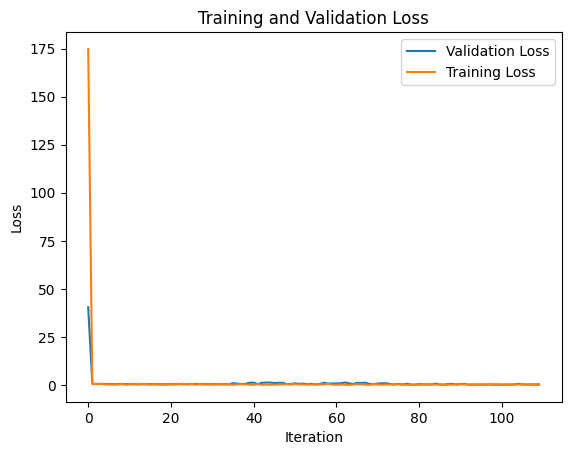

In [12]:
input_size = len(df_train.iloc[0]['mfcc'])
num_classes = len(df_train.iloc[0]['label'])
learning_rate = 1e-2 
model = DNN_FC(input_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_loss_lst, val_loss_lst = train(model, optimizer, scheduler, epochs = 10)



[174.8089141845703, 0.5301408767700195, 0.6358743906021118, 0.6592809557914734, 0.3580632209777832, 0.36646568775177, 0.25653600692749023, 0.27399349212646484, 0.596466064453125, 0.19231833517551422, 0.42001330852508545, 0.46820950508117676, 0.2756541967391968, 0.641600489616394, 0.3805524408817291, 0.20575730502605438, 0.4147431254386902, 0.25712019205093384, 0.25179070234298706, 0.3236498236656189, 0.33540821075439453, 0.3317354619503021, 0.6459417343139648, 0.372113436460495, 0.4218595325946808, 0.5522046685218811, 0.22657561302185059, 0.5214546918869019, 0.328102171421051, 0.2786555588245392, 0.26737913489341736, 0.4267802834510803, 0.3903640806674957, 0.3552439510822296, 0.37123608589172363, 0.19995708763599396, 0.41136959195137024, 0.4088906943798065, 0.36412593722343445, 0.20219433307647705, 0.16898635029792786, 0.49596157670021057, 0.17321158945560455, 0.28228330612182617, 0.1637682318687439, 0.22115568816661835, 0.3314422070980072, 0.33927029371261597, 0.46332693099975586, 0.2

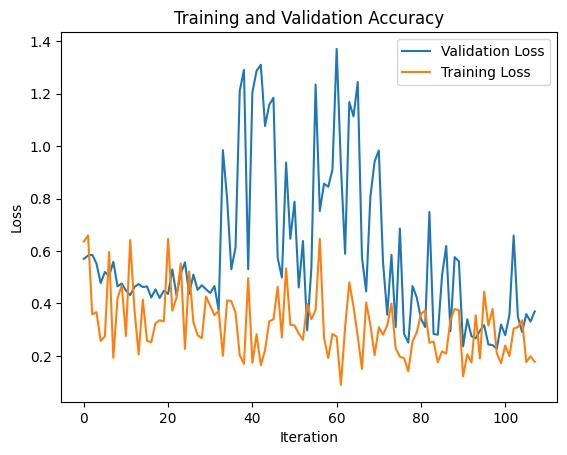

In [13]:
print(train_loss_lst)
print(val_loss_lst) 

# Plot the accuracy values
plt.plot(val_loss_lst[2:], label='Validation Loss')
plt.plot(train_loss_lst[2:], label='Training Loss')

# Add labels and title to the plot
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()




In [14]:
check_accuracy(loader_val, model)
check_accuracy(loader_test, model) 
check_accuracy(loader_train, model) 

loader_train_fortest = DataLoader(dataset_train, batch_size=1,
                                  sampler = sampler.SequentialSampler(range(len(df_train))))
check_accuracy(loader_train_fortest, model) 


Checking accuracy on validation set
Got 2070 / 3099 correct (66.80)
Checking accuracy on test set
Got 11235 / 17249 correct (65.13)
Checking accuracy on validation set
Got 8665 / 32382 correct (26.76)
Checking accuracy on validation set
Got 8665 / 32382 correct (26.76)


0.2675869310110555

In [15]:
check_accuracy_12_classes(loader_val, model)
check_accuracy_12_classes(loader_test, model) 
check_accuracy_12_classes(loader_train, model) 

check_accuracy_12_classes(loader_train_fortest, model) 



Checking accuracy on validation set
Got 21 / 716 correct (2.93)
Checking accuracy on test set
Got 30 / 3667 correct (0.82)
Checking accuracy on validation set
Got 593 / 22847 correct (2.60)
Checking accuracy on validation set
Got 593 / 22847 correct (2.60)


0.025955267650019695

In [16]:
check_accuracy_12_classes(loader_val, model)


Checking accuracy on validation set
Got 21 / 716 correct (2.93)


0.029329608938547486

In [17]:
def infer_probabilities(loader, model):
    if loader.dataset.train:
        print('Getting estimated probabilities on validation set')
    else:
        print('Getting estimated probabilities on test set') 
    model.eval()  # set model to evaluation mode
    probabilities_dict = {} 
    batch_size = loader.batch_size
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):
            y = flatten(y) # Flatten y to convert dimension from (Nx1) to (N,)
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype) 
            scores = model(x) 
            probabilities = torch.softmax(scores, dim=1) 
            
            # Save the probabilities with the corresponding row index
            for i in range(len(probabilities)):
                probabilities_dict[idx * batch_size + i] = probabilities[i].numpy()
    
    return probabilities_dict


def find_emission(loader, model, scale = False):
    '''
    Find emission probabilities for a given data loader and model.
    Consider changing this function if it takes too long. Currently: O(n) 
    Args:
        loader: torch Data loader
        model: torch DNN model
        scale: Boolean: Set true to scale the output probability of DNN.
    Returns:
        emission_df: Dataframe for emission probabilities.
    '''
    # Get the inferred probabilities for each class (12 states, background and silence)
    probabilities_dict = infer_probabilities(loader, model) 
    emission = probabilities_dict
    # Get the prior vector and the transition probabilities. We don't need the transition probabilities.
    prior_vector, _ = get_prob.main(rerun=False) 

    # For each key=row_idx and val=prob_array, convert the inferred probabilities into emission.
    for key, val in emission.items():
        # Slice val to exclude the probabilities for background and silence.
        if scale == True:
            log_prob = np.where(val > 0, np.log(val), -np.inf)   # Get the log probabilities. 
            log_prob = log_prob[:-2]  # Exclude the background and silence in the emission probability calculation. 
            emission[key] = [log_prob-prior_vector]  # Divide by prior vector in the log space. 
        else:
            emission[key] = [val] 

    emission_df = pd.DataFrame.from_dict(emission, orient='index', columns=['Emission']) 
    return emission_df 

In [18]:
prior_vector, _ = get_prob.main(rerun=True)
estimate_prob = infer_probabilities(loader_test, model)
emission_data = find_emission(loader_test, model)


For start 45760 and end 46160, there is no time-overlapping row.
For start 65120 and end 65520, there is no time-overlapping row.
For start 35440 and end 35840, there is no time-overlapping row.
For start 42480 and end 42880, there is no time-overlapping row.
For start 49040 and end 49440, there is no time-overlapping row.
For start 59200 and end 59600, there is no time-overlapping row.
For start 61040 and end 61440, there is no time-overlapping row.
For start 39840 and end 40240, there is no time-overlapping row.
For start 46800 and end 47200, there is no time-overlapping row.
For start 60640 and end 61040, there is no time-overlapping row.
For start 56240 and end 56640, there is no time-overlapping row.
For start 52240 and end 52640, there is no time-overlapping row.
Getting estimated probabilities on test set
Getting estimated probabilities on test set


In [19]:
def path_to_emission(file_path_wav: str, file_path_phn: str):
    '''
    Given the path of a file, get the emission probabilities.
    Args:
        file_path: Path of the audio file as a string.
    Returns:
        emit: pd.dataframe
            Emission probabilities for each frame in the audio file.
    '''
    df_test = mfcc_label.prepare_data(file_path_phn,file_path_wav)
    column_str_to_numpy(df_test, 'mfcc')
    column_str_to_numpy(df_test, 'label')
    # Convert dataframe into a loader so that torch can work with.
    dataset_test = CustomDataset(df_test,train=False)
    loader_test = DataLoader(dataset_test, batch_size=1,
                        sampler=sampler.SequentialSampler(range(len(df_test))))

    emission_data = find_emission(loader_test, model)
    return emission_data
    

path_to_emission('timit/data/TRAIN/DR4/MDCD0/SX425.WAV','timit/data/TRAIN/DR4/MDCD0/SX425.PHN')

Getting estimated probabilities on test set


,Emission
0,"[1.4678845e-09, 3.3755976e-13, 1.389789e-07, 1.395275e-07, 7.747543e-12, 1.2924673e-08, 1.2927175e-10, 0.0035128638, 0.0032323275, 0.00023848638, 8.0125324e-07, 6.4252523e-09, 0.46521556, 0.52779967]"
1,"[4.35341e-10, 6.5701866e-14, 5.783409e-08, 5.1930815e-08, 1.6519694e-12, 4.5113002e-09, 3.9394255e-11, 0.0031483476, 0.002860579, 0.00015545839, 3.869292e-07, 2.304951e-09, 0.532827, 0.46100816]"
2,"[6.19073e-10, 1.0548537e-13, 7.459539e-08, 6.9170234e-08, 2.5834701e-12, 6.121107e-09, 5.558368e-11, 0.003255435, 0.0029686564, 0.00017618967, 4.78122e-07, 3.1028784e-09, 0.51336116, 0.48023787]"
3,"[6.094565e-10, 1.0328696e-13, 7.37567e-08, 6.8294575e-08, 2.5325879e-12, 6.038634e-09, 5.473936e-11, 0.0032506941, 0.0029638526, 0.00017521543, 4.7365023e-07, 3.0621459e-09, 0.51422936, 0.4793803]"
4,"[3.0969243e-09, 9.254017e-13, 2.3753006e-07, 2.5560507e-07, 2.0068353e-11, 2.4641539e-08, 2.6817024e-10, 0.0037260086, 0.0034554722, 0.00030833847, 1.2483939e-06, 1.2043277e-08, 0.42364797, 0.56886035]"
...,...
402,"[1.9986715e-10, 2.3107689e-14, 3.2897734e-08, 2.7525802e-08, 6.155228e-13, 2.2960132e-09, 1.839945e-11, 0.0029099134, 0.0026229026, 0.00011746931, 2.4182717e-07, 1.1935962e-09, 0.5751407, 0.41920862]"
403,"[8.247103e-10, 1.5518598e-13, 9.1750906e-08, 8.734509e-08, 3.719888e-12, 7.847291e-09, 7.357471e-11, 0.0033419253, 0.003056603, 0.00019496205, 5.678174e-07, 3.952321e-09, 0.49740866, 0.49599707]"
404,"[1.185383e-10, 1.1476334e-14, 2.2504208e-08, 1.7964487e-08, 3.176731e-13, 1.4584806e-09, 1.1038005e-11, 0.0027502317, 0.002465814, 9.708487e-05, 1.7613033e-07, 7.6699685e-10, 0.6027574, 0.39192933]"
405,"[2.8298183e-11, 1.6930037e-15, 7.911839e-09, 5.5594693e-09, 5.2012322e-14, 4.1942333e-10, 2.7181092e-12, 0.0023236736, 0.0020535272, 5.7007288e-05, 7.3402255e-08, 2.2757982e-10, 0.6740266, 0.3215391]"


In [20]:
def get_emission_all_paths(path_type: str = 'test'):
    paths = load('processed_data/train_test_dataset_never.joblib')[path_type]
    data = {}
    for i in range(len(paths)):
        file_path_wav, file_path_phn, file_path_word = paths[i]
        emission_data = path_to_emission(file_path_wav, file_path_phn)
        data[(file_path_wav, file_path_phn, file_path_word)] = emission_data

    return data
data = get_emission_all_paths() 

from joblib import dump
dump(data, "processed_data/test_data_for_hmm.joblib")

For start 36960 and end 37360, there is no time-overlapping row.
Caution: There is no time-overlapping rows for start 36960 and end 37360
Getting estimated probabilities on test set
For start 45760 and end 46160, there is no time-overlapping row.
Caution: There is no time-overlapping rows for start 45760 and end 46160
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
For start 62960 and end 63360, there is no time-overlapping row.
Caution: There is no time-overlapping rows for start 62960 and end 63360
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estimated probabilities on test set
Getting estima

['processed_data/test_data_for_hmm.joblib']